In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

In [2]:
scenarios = []
for gre in [i/100 for i in list(range(2, 10))]:
    for gs in [i/100 for i in list(range(2, 10))]:
        for ps in [100]:
            for ma in list(range(0, 20001, 5000)):
                for ia in list(range(0, 20001, 5000)):
                    scenarios.append(utils.Scenario(utils.RealEstate(4.2e6,
                                                                     utils.Mortgage(0.0305, 3.6e6, 30, 12)),
                                                    utils.Portfolio(), gre, gs, ps, ma, ia))


sim = utils.Simulation(scenarios)

In [3]:
%%time
sim.simulate()

Completed scenario 1599.
CPU times: user 1min 8s, sys: 28.1 s, total: 1min 36s
Wall time: 1min 34s


In [4]:
history = sim.history
totals = sim.profit

## Historical Market Development
Let's first calculate the historical annual appreciation for real estate in Norway and the S&P500.

In [10]:
real_estate_price_15_y = 77339
real_estate_price_0_y = 27308
snp500_price_15_y = 3235
snp500_price_0_y = 1186
hist_growth_rate_real_estate = math.pow(real_estate_price_15_y/real_estate_price_0_y, 1/15) - 1
hist_growth_rate_snp500 = math.pow(snp500_price_15_y/snp500_price_0_y, 1/15) - 1

## Real Estate Profit At Various Overpayment Levels
Here, we fix the annual real estate growth rate to its historic levels and compare the real estate profit for various overpayment amounts.

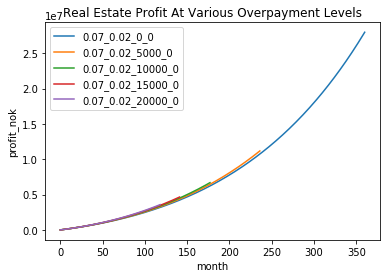

In [17]:
to_plot = history[(history.growth_rate_real_estate==round(hist_growth_rate_real_estate, 2))
                  & (history.growth_rate_stocks==history.growth_rate_stocks.min())
                  & (history.investment_amount==0)]

for scenario in to_plot.scenario_name.unique():
    subplot = history[history.scenario_name==scenario]
    plt.plot(subplot.month, subplot.current_profit_real_estate, label=scenario)

plt.legend()
plt.xlabel('month')
plt.ylabel('profit_nok')
plt.title('Real Estate Profit At Various Overpayment Levels')
plt.show()

## Real Estate Profit At Various Growth Levels With No Overpayment
We will now fix the overpayment to 0 and explore the real estate profit at various annual real estate growth levels.

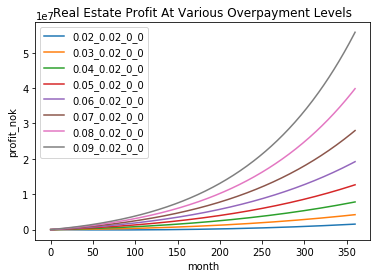

In [20]:
to_plot = history[(history.mortgage_overpayment_amount==0)
                  & (history.growth_rate_stocks==history.growth_rate_stocks.min())
                  & (history.investment_amount==0)]

for scenario in to_plot.scenario_name.unique():
    subplot = history[history.scenario_name==scenario]
    plt.plot(subplot.month, subplot.current_profit_real_estate, label=scenario)

plt.legend()
plt.xlabel('month')
plt.ylabel('profit_nok')
plt.title('Real Estate Profit At Various Overpayment Levels')
plt.show()

In [7]:
# for various periods, with growth real estate on X and growth stocks on Y, what is the profit for various cases
# for various periods, with overpayment real estate on X and investment on Y what is the profit for various cases
# with today's growth rates, what is more profitable - overpayment or investment?